In [9]:
#import sys
#sys.path.append('..')

Retrieve packages and modules

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import torch.optim as optim
import torchvision
import torch.nn as nn
import torch.cuda
import torch.utils.data as td
from torchvision.transforms import RandomRotation, RandomHorizontalFlip, Resize, Normalize, RandomResizedCrop

In [23]:
from transformers import SegformerForSemanticSegmentation, SegformerConfig

In [24]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
import monai

In [25]:
import segmentation_models_pytorch as smp

In [26]:
from data_sets import SynData, AngioData

Define constants for use in standardizing data

In [27]:
syn_mean = 127.7000
syn_std = 49.2788
act_mean = 0.4333
act_std = 0.1341

Define functions

In [28]:
def compute_data_mean_std(data_iter):
    means = 0
    stds = 0
    for i in range(len(data_iter)):
        img, _ = next(data_iter)
        means += img.mean()
        stds += img.std()
    
    means/=len(data_iter)
    stds/=len(stds)
    return means, stds

In [29]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [30]:
def train_and_val_model(model, device, train_loader, val_loader, optim, loss_fn, epochs, stopper):
    losses = []
    val_losses = []
    for epoch in range(1, epochs+1):  # loop over the dataset multiple times
        print("Epoch:", epoch)
        pbar = tqdm(train_loader)#syn_train_loader)
        run_losses = []
        run_val_losses = []
        model.train()
        for idx, batch in enumerate(pbar):
            # get the inputs;
            pixel_values, labels = batch

            #transfer data to device, e.g. GPU
            pixel_values, labels = pixel_values.to(device), labels.to(device)

            # zero the parameter gradients
            optim.zero_grad()

            # forward
            predicted = model(pixel_values.float()) #Should not do anything bad

            predicted = predicted.sigmoid()

            #accuracy = accuracy_score(pred_labels, true_labels)
            loss = loss_fn(predicted, labels.float())
            #accuracies.append(accuracy)
            run_losses.append(loss.item())

            loss.backward()
            optim.step()
        else:
            model.eval()
            with torch.no_grad():
                for idx, batch2 in enumerate(val_loader):#syn_val_loader):
                    pixel_values, labels = batch2

                    #transfer data to device, e.g. GPU
                    pixel_values, labels = pixel_values.to(device), labels.to(device)

                    predicted = model(pixel_values.float())
                    predicted = predicted.sigmoid()
            
                    val_loss = loss_fn(predicted, labels.float())
                    #val_accuracies.append(accuracy)
                    run_val_losses.append(val_loss.item())
        losses.append(sum(run_losses)/len(run_losses))
        val_losses.append(sum(run_val_losses)/len(run_val_losses))
        print(f"Train Loss: {losses[epoch-1]}\
             Val Loss: {val_losses[epoch-1]}") #Tog 10 min før
        if stopper.early_stop(val_losses[epoch-1]):
            break
    return model, losses, val_losses

In [31]:
def train_and_val_model_hf(model, device, train_loader, val_loader, optim, loss_fn, epochs, stopper):
    losses = []
    val_losses = []
    for epoch in range(1, epochs+1):  # loop over the dataset multiple times
        print("Epoch:", epoch)
        pbar = tqdm(train_loader)#syn_train_loader)
        run_losses = []
        run_val_losses = []
        model.train()
        for idx, batch in enumerate(pbar):
            # get the inputs;
            pixel_values, labels = batch

            #transfer data to device, e.g. GPU
            pixel_values, labels = pixel_values.to(device), labels.to(device)

            # zero the parameter gradients
            optim.zero_grad()

            # forward
            predicted = model(pixel_values.float()).logits #Should not do anything bad

            predicted = predicted.sigmoid()

            #accuracy = accuracy_score(pred_labels, true_labels)
            loss = loss_fn(predicted, labels.float())
            #accuracies.append(accuracy)
            run_losses.append(loss.item())

            loss.backward()
            optim.step()
        else:
            model.eval()
            with torch.no_grad():
                for idx, batch2 in enumerate(val_loader):#syn_val_loader):
                    pixel_values, labels = batch2

                    #transfer data to device, e.g. GPU
                    pixel_values, labels = pixel_values.to(device), labels.to(device)

                    predicted = model(pixel_values.float()).logits
                    predicted = predicted.sigmoid()
            
                    val_loss = loss_fn(predicted, labels.float())
                    #val_accuracies.append(accuracy)
                    run_val_losses.append(val_loss.item())
        losses.append(sum(run_losses)/len(run_losses))
        val_losses.append(sum(run_val_losses)/len(run_val_losses))
        print(f"Train Loss: {losses[epoch-1]}\
             Val Loss: {val_losses[epoch-1]}") #Tog 10 min før
        if stopper.early_stop(val_losses[epoch-1]):
            break
    return model, losses, val_losses

Define data augmentations and data paths

In [32]:
syn_data_path = r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\local_data\syn_data\syn_data"
data_path = r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\local_data\data\Data"
transformations = [
    RandomRotation(degrees=(-10, 10)),
    RandomResizedCrop(size=(736, 736), scale=(0.7, 1), ratio=(0.9, 1.1)),
    RandomHorizontalFlip(p=0.5), 
]
syn_norm = [Normalize(mean=syn_mean, std=syn_std)]
act_norm = [Normalize(mean=act_mean, std=act_std)]

Retrieve data into datasets

In [33]:
syn_dat = SynData(syn_data_path + "/syn_input", syn_data_path + "/syn_label", transforms_train=syn_norm)
syn_train, syn_val, syn_test = td.random_split(syn_dat, [0.6, 0.2, 0.2])


act_train = AngioData(data_path + r"\train\Orig", data_path + r"\train\Annotations", transforms_train=act_norm, transforms_both=transformations)
act_test = AngioData(data_path + r"\test\Orig", data_path + r"\test\Annotations", transforms_train=act_norm)
act_val = AngioData(data_path + r"\val\Orig", data_path + r"\val\Annotations", transforms_train=act_norm)

Define data loaders

In [34]:
syn_train_loader = td.DataLoader(syn_train, batch_size=4, shuffle=True)
syn_val_loader = td.DataLoader(syn_val, batch_size=4, shuffle=True)
syn_test_loader = td.DataLoader(syn_test, shuffle=True)

act_train_loader = td.DataLoader(act_train, batch_size=4, shuffle=True)
act_val_loader = td.DataLoader(act_val, batch_size=4, shuffle=True)
act_test_loader = td.DataLoader(act_test, shuffle=True)

Get Device

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


cuda:0


Define model hyper-parameters

In [174]:
epochs = 1000
lr_lst =[(0.01, 3)]#, (0.00001, 6)]# [(0.0001, 3), (0.00001, 8)]#[(0.01, 1), (0.001, 1), (0.0001, 2), (0.00001, 3)]#, (0.00001, 10)]#[ (0.01, 10), (0.001, 15), (0.0001, 30), (0.00001, 50)]#[ (0.01, 10), (0.001, 10), (0.0001, 20), (0.00001, 30)]
loss_fn_lst = [ ("BCE", nn.BCELoss()), ("DiceLoss", monai.losses.dice.DiceLoss())]

Train SegFormer using different hyperparameters

In [175]:
#best = 0
for loss_name,  loss_func in loss_fn_lst:
    for lr_current, pat in lr_lst:
        #define model
        config = SegformerConfig()
        config.num_channels = 1
        config.num_labels = 1
        segformer = SegformerForSemanticSegmentation(config)
        segformer.decode_head.classifier = nn.ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(4, 4)) #Done to upsample logits to 736 x 736. We need to upsample anyway, why not do it in decoder where we can also learn 'how' to upsample

        #load weights
        #segformer.load_state_dict(torch.load((r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models/SegFormer/" + "syntrained_SegFormer_BCE_Adam_0.0001_" + ".txt")))
        
        #export model to device
        segformer.to(device)
        loss_fn = loss_func
        optimizer = optim.Adam(segformer.parameters(), lr=lr_current)
        earlyStopper = EarlyStopper(patience=pat, min_delta=0.001)

        #train model
        segformer_trained, loss, val_loss = train_and_val_model_hf(segformer, device, act_train_loader, act_val_loader, optimizer, loss_fn, epochs, earlyStopper)

        #Save model
        model_name = "SegFormer_" + loss_name + "_Adam_" + str(lr_current) + "_"
        torch.save(segformer_trained.state_dict(), (r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models\SegFormer" + "/" + model_name + ".txt"))
        np.savetxt(r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\SegFormer" + "/" + model_name + "_trainloss.txt", loss)
        np.savetxt(r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\SegFormer"  + "/"+ model_name + "_valloss.txt", val_loss)

        #tp, fp, fn, tn
        #Compute metrics
        segformer.load_state_dict(torch.load((r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models/SegFormer/" + model_name + ".txt")))
        confusion_mat = torch.tensor([0.0, 0.0, 0.0, 0.0])
        for idx, batch2 in enumerate(act_test_loader):
            img, labels = batch2
            pred = segformer_trained(img.to(device).float()).logits

            pred = pred.sigmoid()
            pred = (pred > 0.5)
            confusion_mat += np.array(smp.metrics.get_stats(pred.detach().cpu(), labels, mode='binary'))

        #save metrics
        confusion_mat = confusion_mat / len(act_test_loader)
        np.savetxt(r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\confusion_mat"  + "/"+ model_name + "_confusion.txt", confusion_mat)

Epoch: 1


100%|██████████| 6/6 [00:14<00:00,  2.48s/it]


Train Loss: 0.5914908349514008             Val Loss: 0.7448261082172394
Epoch: 2


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Train Loss: 0.4099424829085668             Val Loss: 0.6400988101959229
Epoch: 3


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Train Loss: 0.44839543104171753             Val Loss: 0.6368511021137238
Epoch: 4


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Train Loss: 0.3916776676972707             Val Loss: 0.3375170975923538
Epoch: 5


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Train Loss: 0.3779049019018809             Val Loss: 0.29593828320503235
Epoch: 6


100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


Train Loss: 0.32168565193812054             Val Loss: 0.31056755781173706
Epoch: 7


100%|██████████| 6/6 [00:13<00:00,  2.18s/it]


Train Loss: 0.31182563801606494             Val Loss: 0.27423107624053955
Epoch: 8


100%|██████████| 6/6 [00:14<00:00,  2.35s/it]


Train Loss: 0.30258098244667053             Val Loss: 0.28693290054798126
Epoch: 9


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Train Loss: 0.3094496577978134             Val Loss: 0.2617650106549263
Epoch: 10


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Train Loss: 0.3026919513940811             Val Loss: 0.2563600689172745
Epoch: 11


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Train Loss: 0.2976357042789459             Val Loss: 0.2530123144388199
Epoch: 12


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Train Loss: 0.29623597860336304             Val Loss: 0.25147850066423416
Epoch: 13


100%|██████████| 6/6 [00:13<00:00,  2.33s/it]


Train Loss: 0.29611024012168247             Val Loss: 0.2531033903360367
Epoch: 14


100%|██████████| 6/6 [00:14<00:00,  2.46s/it]


Train Loss: 0.30299940208594006             Val Loss: 0.2525995001196861
Epoch: 15


100%|██████████| 6/6 [00:15<00:00,  2.60s/it]


Train Loss: 0.2976277867952983             Val Loss: 0.2529391646385193


Visualize loss of Segformer models

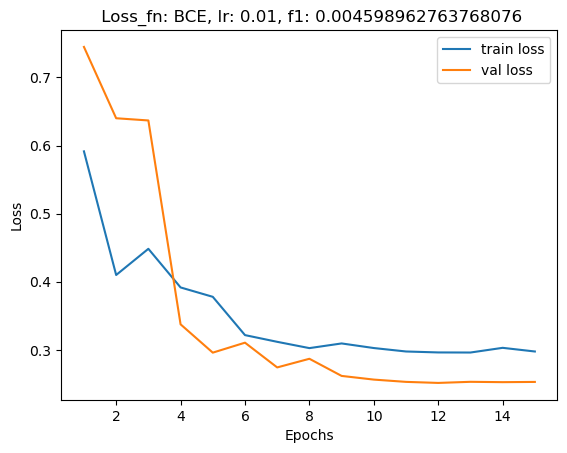

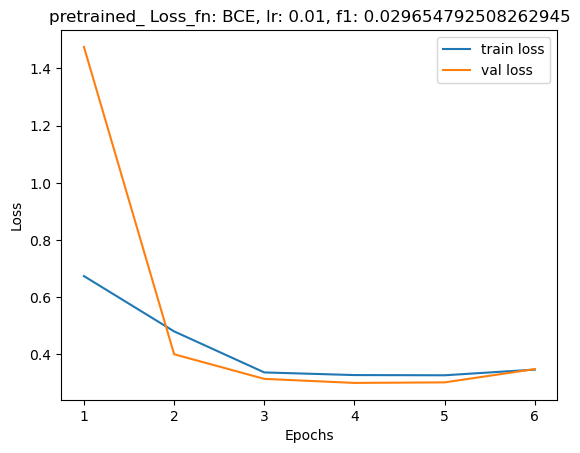

In [198]:
for loss_name, loss in loss_fn_lst:
    for lr_current, _ in lr_lst:
        for m_precursor in ["", "pretrained_"]:#["pretrained_", "syntrained_", ""]:
            model_name = m_precursor + "SegFormer_" + loss_name + "_Adam_" + str(lr_current) + "_"
            #torch.save(model.state_dict(), (r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models\SegFormer" + "/" + model_name + ".txt"))
            losses = np.loadtxt(r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\SegFormer" + "/" + model_name + "_trainloss.txt")
            val_losses = np.loadtxt(r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\SegFormer" + "/" + model_name + "_valloss.txt")
            confusion_mat = np.loadtxt(r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\confusion_mat"  + "/"+ model_name + "_confusion.txt")
            confusion_mat = torch.tensor(confusion_mat)
            f1_score = smp.metrics.functional.f1_score(confusion_mat[0], confusion_mat[1], confusion_mat[2], confusion_mat[3])
            plt.plot(np.arange(len(losses))+1, losses, '-', label="train loss")
            plt.plot(np.arange(len(losses))+1, val_losses, '-', label = "val loss")
            plt.ylabel("Loss")
            plt.xlabel("Epochs")
            plt.title(m_precursor + " Loss_fn: {0}, lr: {1}, f1: {2}".format(loss_name, lr_current, f1_score))
            plt.legend()
            plt.show()

Define hyperparameters to train ResUnet on. This is different only because ResUnet converges a bit slower than SegFormer. As such early stopping is performed differently

In [199]:

lr_lst = [(0.00025, 10), (0.0005, 10), (0.00075, 15), (0.000025, 25), (0.00005, 25), (0.000075, 30)]#[ (0.01, 15), (0.001, 30), (0.0001, 50), (0.00001, 50)]#[ (0.01, 10), (0.001, 10), (0.0001, 20), (0.00001, 30)]#[0.0025, 0.005, 0.0075, 0.01, 0.001, 0.0001, 0.00001]
loss_fn_lst = [("DiceLoss", monai.losses.dice.DiceLoss()), ("BCE", nn.BCELoss())]#[("DiceLoss", monai.losses.dice.DiceLoss()), ("BCE", nn.BCELoss())]

#For aftertraining: lr_lst [ (0.01, 10), (0.001, 10), (0.0001, 20), (0.00001, 30)]
#For pretraining: patience = 3, 5, 7, 10
#For no pretraining: patience= 15, 30, 50, 50 

Train different models

Train ResUnet

In [329]:
#best = 0
for loss_name,  loss_func in loss_fn_lst:
    for lr_current, pat in lr_lst:
        #define model
        model = monai.networks.nets.UNet(
            spatial_dims=2,
            in_channels=1,
            out_channels=1,
            channels=(16, 32, 64, 128, 256),
            strides=(2, 2, 2, 2),
            num_res_units=2
        )
        #load weights
        model.load_state_dict(torch.load((r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models/Unet_large/" + "syntrained_ResUnet_large_DiceLoss_Adam_0.0025_" + ".txt")))
        
        #export model to device
        model.to(device)
        loss_fn = loss_func
        optimizer = optim.Adam(model.parameters(), lr=lr_current)
        earlyStopper = EarlyStopper(patience=pat, min_delta=0.001)
        trained_model, loss, val_loss = train_and_val_model(model, device, act_train_loader, act_val_loader, optimizer, loss_fn, epochs, earlyStopper)
        model_name = "pretrained_ResUnet_large_" + loss_name + "_Adam_" + str(lr_current) + "_"
        torch.save(trained_model.state_dict(), (r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models\Unet_large" + "/" + model_name + ".txt"))
        np.savetxt(r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\Unet_large" + "/" + model_name + "_trainloss.txt", loss)
        np.savetxt(r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\Unet_large"  + "/"+ model_name + "_valloss.txt", val_loss)
        #tp, fp, fn, tn
        model.load_state_dict(torch.load((r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models/Unet_large/" + model_name + ".txt")))
        model.to(device)
        confusion_mat = torch.tensor([0.0, 0.0, 0.0, 0.0])
        for idx, batch2 in enumerate(act_test_loader):
            img, labels = batch2
            pred = trained_model(img.to(device).float())
            #plt.imshow(img.numpy()[0][0], cmap="gray")
            #plt.show()
            pred = pred.sigmoid()
            pred = (pred > 0.5)
            confusion_mat += np.array(smp.metrics.get_stats(pred.detach().cpu(), labels, mode='binary'))
            #f1_score = smp.metrics.functional.f1_score(tp, fp, fn, tn)
            #plt.imshow(pred.detach().cpu().numpy()[0][0], cmap="gray")
            #plt.show()
        confusion_mat = confusion_mat / len(act_test_loader)
        #np.savetxt(r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\confusion_mat"  + "/"+ model_name + "_confusion.txt", confusion_mat)
        #f1_score = smp.metrics.functional.f1_score(confusion_mat[0], confusion_mat[1], confusion_mat[2], confusion_mat[3])
        #if f1_score >= best:
        #    best = f1_score
        #    best_lr = lr_current
        #    best_loss = loss_name

        

SyntaxError: invalid syntax (315775433.py, line 17)

Visualize training loss for ResUnet

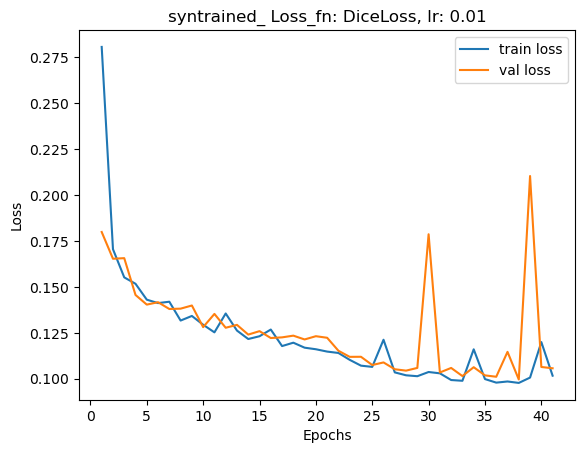

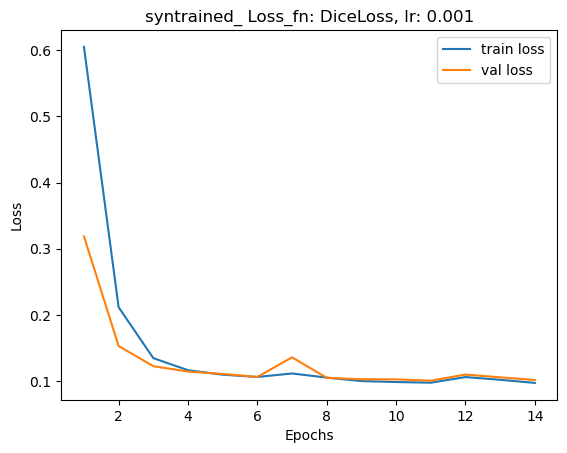

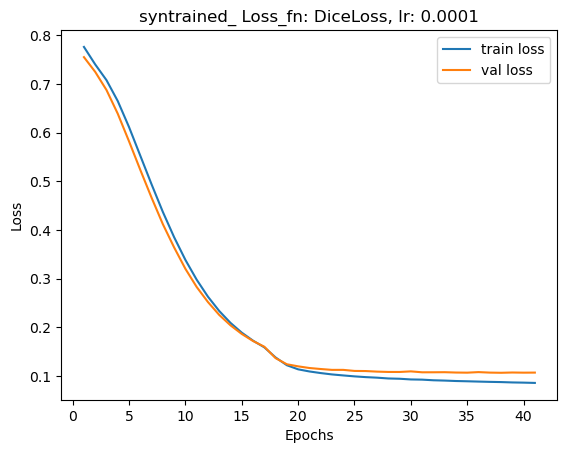

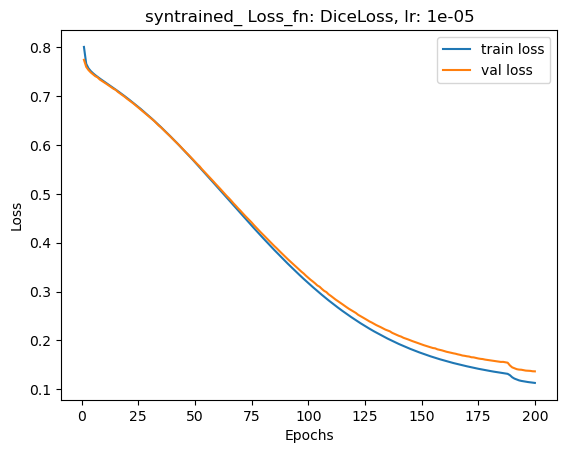

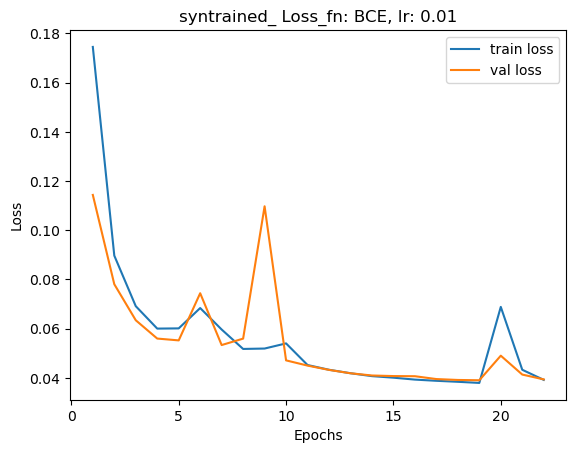

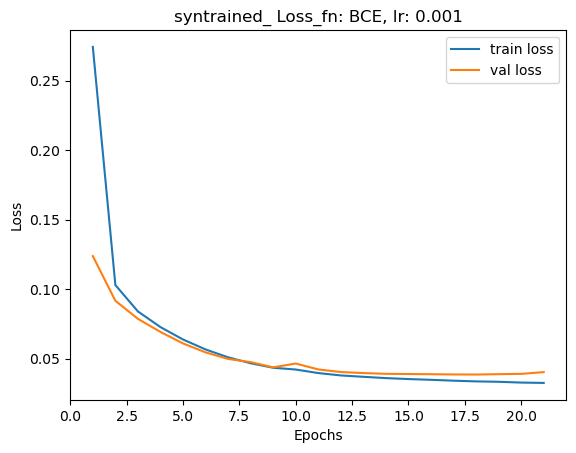

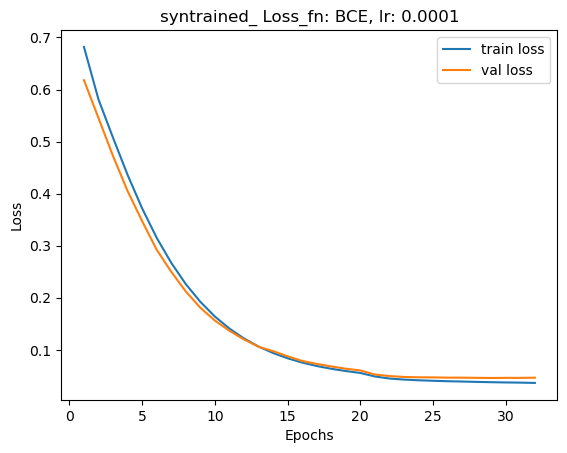

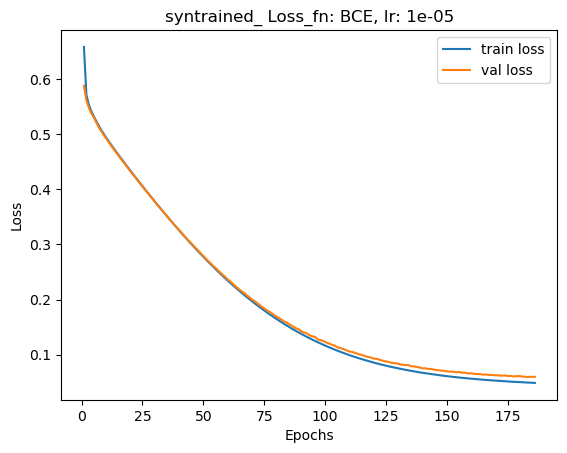

In [188]:
for loss_name, loss in [("DiceLoss", monai.losses.dice.DiceLoss()), ("BCE", nn.BCELoss())]:
    for lr_current in [  0.01, 0.001, 0.0001, 0.00001]:
        for m_precursor in ["syntrained_"]:#["syntrained_"]:#["pretrained_", "syntrained_", ""]:
            model_name = m_precursor + "ResUnet_large_" + loss_name + "_Adam_" + str(lr_current) + "_"
            #torch.save(model.state_dict(), (r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models\Unet_large" + "/" + model_name + ".txt"))
            losses = np.loadtxt(r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\Unet_large" + "/" + model_name + "_trainloss.txt")
            val_losses = np.loadtxt(r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\Unet_large" + "/" + model_name + "_valloss.txt")
            #confusion_mat = np.loadtxt(r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\confusion_mat"  + "/"+ model_name + "_confusion.txt")
            #confusion_mat = torch.tensor(confusion_mat)
            #f1_score = smp.metrics.functional.f1_score(confusion_mat[0], confusion_mat[1], confusion_mat[2], confusion_mat[3])
            plt.plot(np.arange(len(losses))+1, losses, '-', label="train loss")
            plt.plot(np.arange(len(losses))+1, val_losses, '-', label = "val loss")
            plt.ylabel("Loss")
            plt.xlabel("Epochs")
            plt.title(m_precursor + " Loss_fn: {0}, lr: {1}".format(loss_name, lr_current))
            plt.legend()
            plt.show()
#Best syn: Diceloss w. lr=0.0025
#Best no pretrain: 0.780 f1
#best w pretrain: 
#higher loss for val, probably due to train being augmented, and val not being augmented. So training data is more difficult to learn. See bigger difference when using pretraining probably because here we did not use augs. So pretraining already predicts val well. 

Print and format f1 metrics of models for report

In [187]:
import os
path = r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\Losses\confusion_mat"
files = os.listdir(path)

best = files[0]
best_f1 = 0
for f in files:
    file_path = path + "/" + f
    confusion = torch.tensor(np.loadtxt(file_path))
    f1 = smp.metrics.functional.f1_score(confusion[0], confusion[1], confusion[2], confusion[3])
    prec = smp.metrics.functional.precision(confusion[0], confusion[1], confusion[2], confusion[3])
    recall = smp.metrics.functional.recall(confusion[0], confusion[1], confusion[2], confusion[3])
    acc = smp.metrics.functional.accuracy(confusion[0], confusion[1], confusion[2], confusion[3])
    #dice = monai.metrics.GeneralizedDiceScore()
    if f[0:len("SegFormer")] == "SegFormer":
        #if f1 > best_f1:
        best_f1 = f1
        print(f)
        print("{:0.4f} & {:0.4f} & {:0.4f} & {:0.4f} ".format(prec, recall, acc, f1))


SegFormer_BCE_Adam_0.0001__confusion.txt
0.8631 & 0.6060 & 0.9591 & 0.7121 
SegFormer_BCE_Adam_0.001__confusion.txt
0.7651 & 0.7437 & 0.9595 & 0.7542 
SegFormer_BCE_Adam_0.01__confusion.txt
0.3343 & 0.0023 & 0.9163 & 0.0046 
SegFormer_BCE_Adam_1e-05__confusion.txt
0.7795 & 0.6505 & 0.9554 & 0.7092 
SegFormer_DiceLoss_Adam_0.0001__confusion.txt
0.7634 & 0.7338 & 0.9588 & 0.7483 
SegFormer_DiceLoss_Adam_0.001__confusion.txt
0.8096 & 0.7290 & 0.9631 & 0.7672 
SegFormer_DiceLoss_Adam_0.01__confusion.txt
0.1195 & 0.8512 & 0.4640 & 0.2096 
SegFormer_DiceLoss_Adam_1e-05__confusion.txt
0.4995 & 0.7951 & 0.9163 & 0.6136 


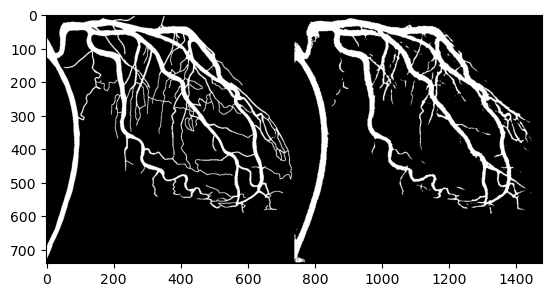

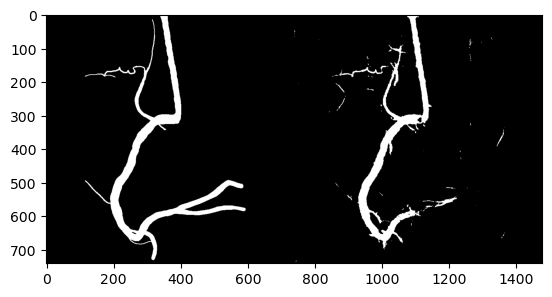

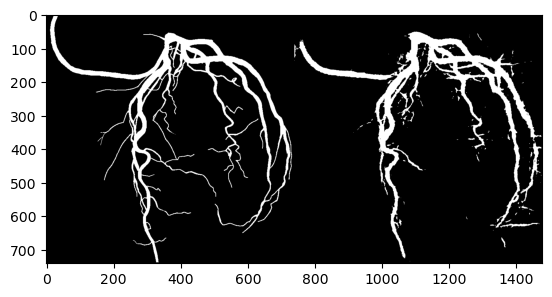

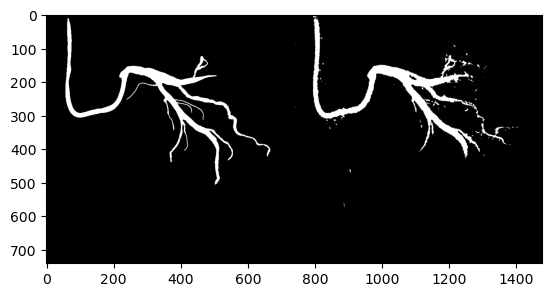

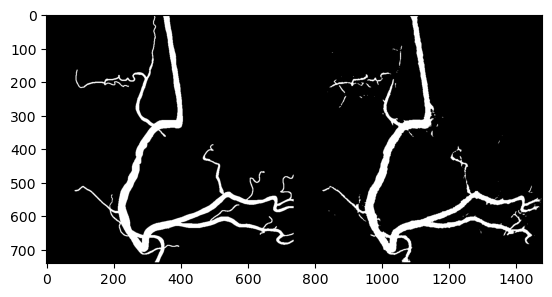

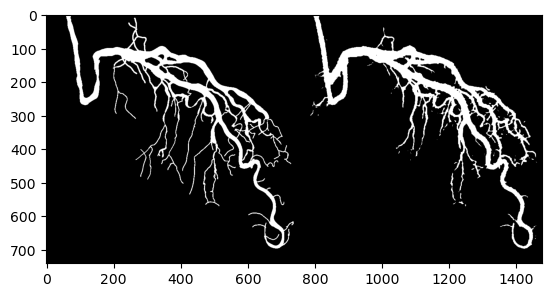

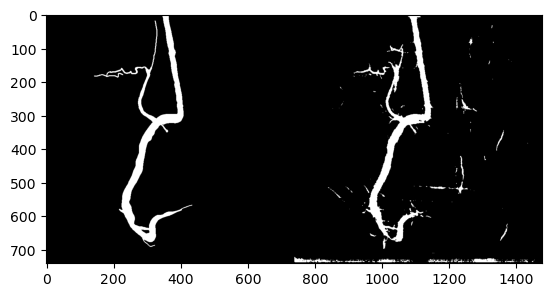

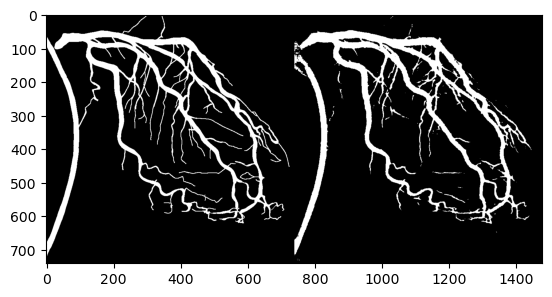

In [215]:
iter_act = iter(act_test_loader)
config = SegformerConfig()
config.num_channels = 1
config.num_labels = 1
model = SegformerForSemanticSegmentation(config)
model.decode_head.classifier = nn.ConvTranspose2d(256, 1, kernel_size=(4, 4), stride=(4, 4)) #Done to upsample logits to 736 x 736. We need to upsample anyway, why not do it in decoder where we can also learn 'how' to upsampl
#load weights
model.load_state_dict(torch.load((r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models/SegFormer/" + "pretrained_SegFormer_DiceLoss_Adam_0.0001_" + ".txt")))
model.to(device)
#
#ResUnet = monai.networks.nets.UNet(
#    spatial_dims=2,
#    in_channels=1,
#    out_channels=1,
#    channels=(16, 32, 64, 128, 256),
#    strides=(2, 2, 2, 2),
#    num_res_units=2
#)
##load weights
#ResUnet.load_state_dict(torch.load((r"C:\Users\nugni\OneDrive\Skrivebord\Bachelor\Bachelor_rep_angiograms\src\saved_models/Unet_large/" + "ResUnet_large_BCE_Adam_0.001_" + ".txt")))
#ResUnet.to(device)


for i in range(len(act_test_loader)):
    img, lab = next(iter_act)
    pred = model(img.to(device).float()).logits
    pred = pred.sigmoid()
    pred = (pred > 0.5)

    #pred2 = ResUnet(img.to(device).float())
    #pred2 = pred2.sigmoid()
    #pred2 = (pred2 > 0.5)
    predlab = torch.cat((lab, pred.detach().cpu()), dim=0)
    grid = torchvision.utils.make_grid(predlab)
    #plt.imshow(img.numpy()[0][0], cmap="gray")
    #plt.imsave("imgs/" +str(i) +"_orig.PNG", img.numpy()[0][0], cmap="gray")
    #plt.show()
    plt.imshow(grid.numpy()[0], cmap="gray")
    #plt.imsave("imgs/" +str(i) +"_labs.PNG",grid.numpy()[0], cmap="gray")
    plt.show()